In [68]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from load import *

In [69]:
root_path = 'D:/Cours/DataCamp/project/cityscapes'

In [70]:
train_dataset=Cityscapes(root_path, 
                split='train', 
                mode='fine', 
                target_type='color', 
                transform=torchvision.transforms.Compose([transforms.Scale(size=(32,64)),transforms.ToTensor()]), 
                target_transform=torchvision.transforms.Compose([transforms.Scale(size=(32,64)),transforms.ToTensor()]))

In [71]:
print(type(train_dataset))
print(len(train_dataset))
print(type(train_dataset[0]))
print(len(train_dataset[0]))
print(type(train_dataset[0][1]))
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

<class 'load.Cityscapes'>
2975
<class 'tuple'>
2
<class 'torch.Tensor'>
torch.Size([3, 32, 64])
torch.Size([4, 32, 64])


In [72]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

In [73]:
test_dataset=Cityscapes(root_path, 
                split='test', 
                mode='fine', 
                target_type='color', 
                transform=torchvision.transforms.Compose([transforms.Scale(size=(32,64)),transforms.ToTensor()]), 
                target_transform=torchvision.transforms.Compose([transforms.Scale(size=(32,64)),transforms.ToTensor()]))

In [74]:
print(len(test_dataset))
print(type(test_dataset[0][1]))
print(test_dataset[0][1])

1525
<class 'torch.Tensor'>
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
        

In [75]:
from BasicBlocks import * 

class UnetGenerator(nn.Module):

    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
                nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),)

    def forward(self,input):
        
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)
        
        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)

        out = self.out(up_4)

        return out

In [76]:
epochs=1
lr = 0.0002

generator = UnetGenerator(3,4,32)
optimizer = torch.optim.Adam(generator.parameters(),lr=lr)
loss_fn = nn.MSELoss()


------Initiating U-Net------



In [77]:

for epoch in range(epochs):
    suivi=0
    print("Epoch "+str(epoch))
    for batch_id, (source, target) in enumerate(train_loader):
        suivi+=1
        target=target.float()
        optimizer.zero_grad()
        x = Variable(source)
        y_ = Variable(target)
        y = generator.forward(x)
        loss = loss_fn(y,y_)
        loss.backward()
        optimizer.step()
        if suivi%10:
            print("num "+str(suivi))

Epoch 0
num 1
num 2
num 3
num 4
num 5
num 6
num 7
num 8
num 9
num 11
num 12
num 13
num 14
num 15
num 16
num 17
num 18
num 19
num 21
num 22
num 23
num 24
num 25
num 26
num 27
num 28
num 29
num 31
num 32
num 33
num 34
num 35
num 36
num 37
num 38
num 39
num 41
num 42
num 43
num 44
num 45
num 46
num 47
num 48
num 49
num 51
num 52
num 53
num 54
num 55
num 56
num 57
num 58
num 59
num 61
num 62
num 63
num 64
num 65
num 66
num 67
num 68
num 69
num 71
num 72
num 73
num 74
num 75
num 76
num 77
num 78
num 79
num 81
num 82
num 83
num 84
num 85
num 86
num 87
num 88
num 89
num 91
num 92
num 93


In [78]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

In [79]:
suivi=0
set_source=[]
set_target=[]
set_output=[]
for batch_id, (source, target) in enumerate(test_loader):
    suivi+=1
    #target=target.float()
    x = Variable(source)
    #y_ = Variable(target)
    y = generator.forward(x)
    #loss = loss_fn(y,y_)
    set_source.append(source)
    set_output.append(y)
    if suivi%10:
        print("num "+str(suivi))
    if batch_id==10:
        break

num 1
num 2
num 3
num 4
num 5
num 6
num 7
num 8
num 9
num 11


In [80]:
print(len(set_output))
print(len(set_output[0]))
print(set_output[0][0].shape)

11
32
torch.Size([4, 32, 64])


In [81]:
def show(img):
    npimg = img.detach().numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


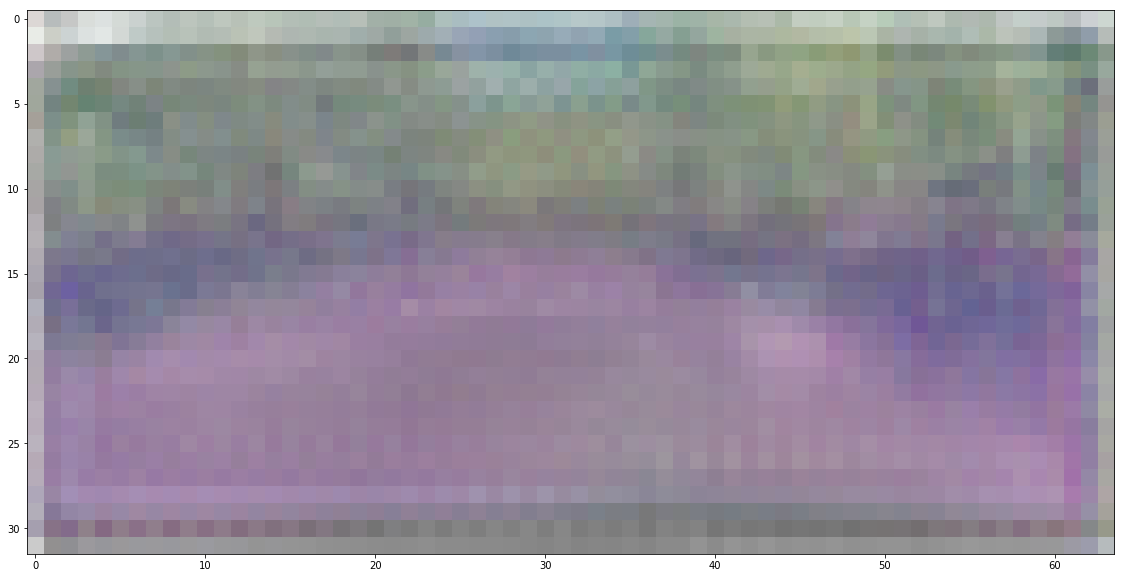

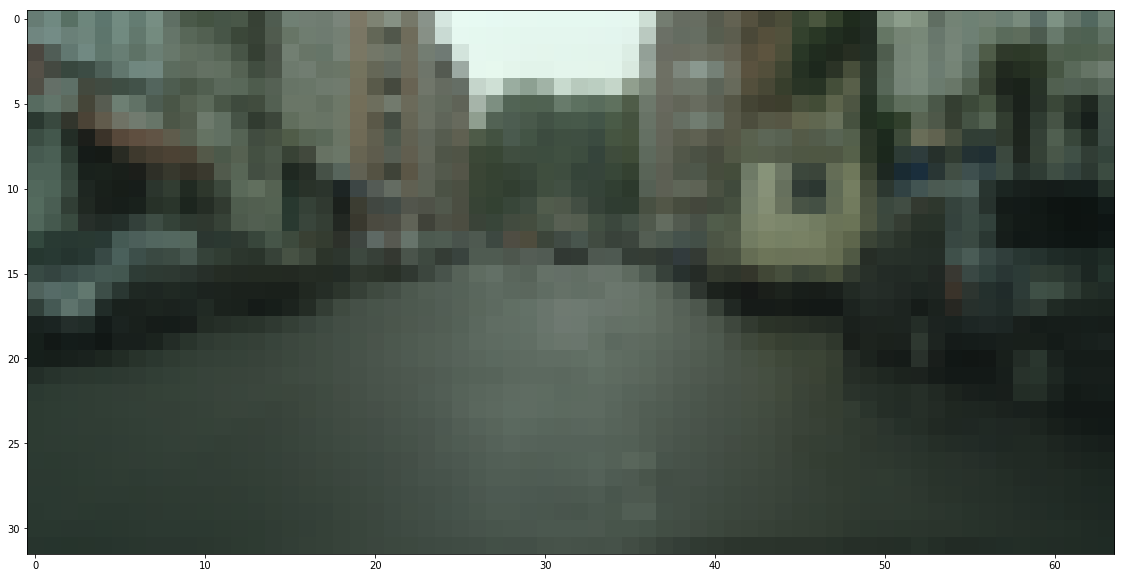

In [84]:
show(set_output[0][3])
show(set_source[0][3])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


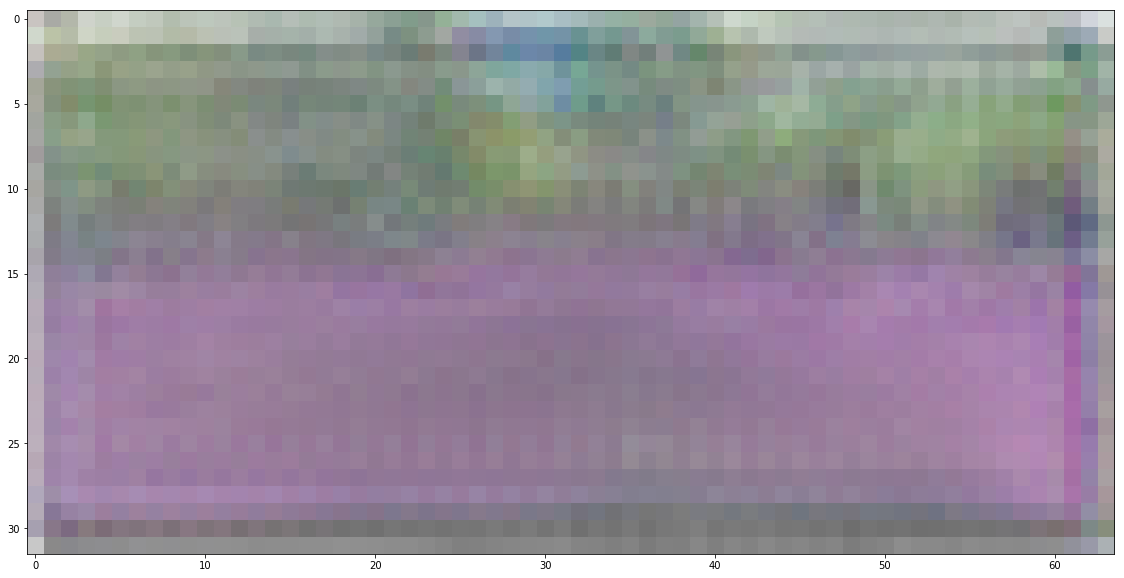

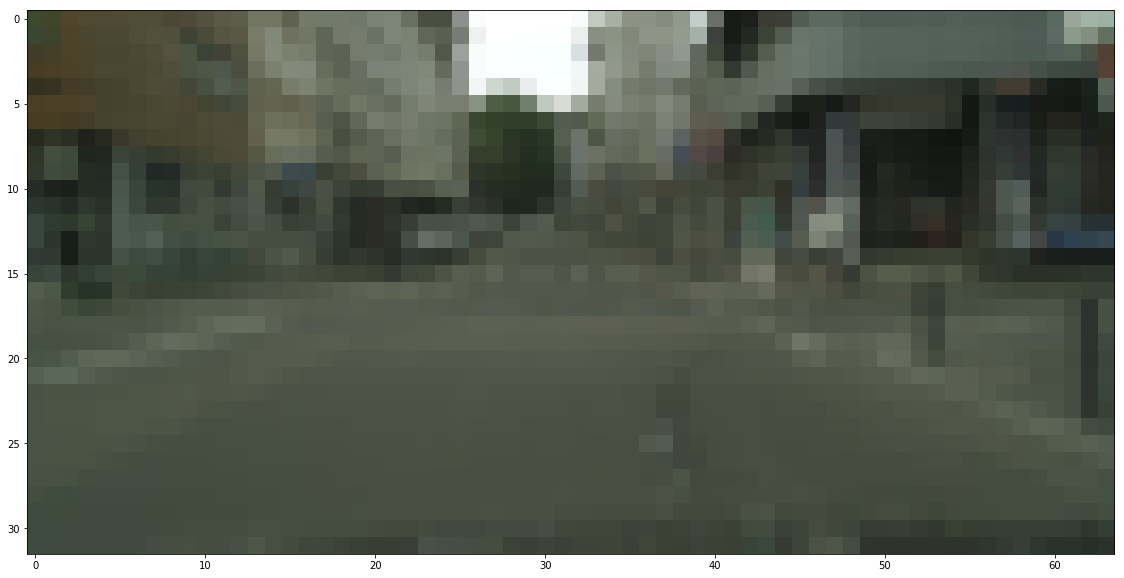

In [86]:
show(set_output[5][17])
show(set_source[5][17])
plt.show()